In [125]:
# you need to install prophet with: 
#conda install -c conda-forge fbprophet

In [10]:
import pandas as pd
import fbprophet as prophet
import numpy as np

# Load and observe the data

In [11]:
dataset = pd.read_csv("Country_Level_Info_updated.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32336 entries, 0 to 32335
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Date                       32336 non-null  object
 1   Country_Region             32336 non-null  object
 2   alpha-3_code               31648 non-null  object
 3   Population                 32336 non-null  int64 
 4   Total_Confirmed_Cases      32336 non-null  int64 
 5   Total_Fatalities           32336 non-null  int64 
 6   Total_Recovered_Cases      32336 non-null  int64 
 7   New_Confirmed_Cases        32336 non-null  int64 
 8   New_Fatalities             32336 non-null  int64 
 9   New_Recovered_Cases        32336 non-null  int64 
 10  Remaining_Confirmed_Cases  32336 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 2.7+ MB


In [14]:
dataset.describe()

,Population,Total_Confirmed_Cases,Total_Fatalities,Total_Recovered_Cases,New_Confirmed_Cases,New_Fatalities,New_Recovered_Cases,Remaining_Confirmed_Cases
count,3.233600e+04,3.233600e+04,32336.000000,3.233600e+04,32336.000000,32336.000000,32336.000000,3.233600e+04
mean,4.018555e+07,1.834432e+04,1039.456674,8.092458e+03,393.304923,17.477053,216.640865,9.212404e+03
std,1.457862e+08,1.166508e+05,6583.089035,4.510286e+04,2451.134781,112.284577,1728.664745,7.336069e+04
min,8.010000e+02,0.000000e+00,0.000000,0.000000e+00,-10034.000000,-1918.000000,-2637.000000,0.000000e+00
25%,2.245639e+06,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
50%,9.511516e+06,1.410000e+02,2.000000,2.200000e+01,1.000000,0.000000,0.000000,5.900000e+01
75%,2.956375e+07,2.472250e+03,54.000000,8.520000e+02,57.000000,1.000000,15.000000,1.077000e+03
max,1.392730e+09,3.245925e+06,134777.000000,1.244088e+06,66627.000000,2614.000000,140050.000000,2.115572e+06


In [15]:
dataset.head()
dataset.shape

(32336, 11)

In [16]:
print("First day: ", dataset["Date"].min(), "\nLast day:", dataset["Date"].max(), "\nNum of recorded days:", dataset["Date"].nunique())

First day:  2020-01-22 
Last day: 2020-07-11 
Num of recorded days: 172


In [17]:
dataset.tail()
dataset.drop(dataset.tail(5670).index,inplace=True) # drop last one month's data
dataset.tail()
dataset.shape #Should be 142 after dropping 30 days for the purpose of comparison of the prediction with actual
print("First day: ", dataset["Date"].min(), "\nLast day:", dataset["Date"].max(), "\nNum of recorded days:", dataset["Date"].nunique())

First day:  2020-01-22 
Last day: 2020-06-11 
Num of recorded days: 142


# Remove uncessary columns with null values (prepare data)

In [18]:
print(dataset["Country_Region"].nunique(), "countries recorded")

188 countries recorded


In [19]:
dataset.isna().any() # alpha-3_code is the only column with missing values

Date                         False
Country_Region               False
alpha-3_code                  True
Population                   False
Total_Confirmed_Cases        False
Total_Fatalities             False
Total_Recovered_Cases        False
New_Confirmed_Cases          False
New_Fatalities               False
New_Recovered_Cases          False
Remaining_Confirmed_Cases    False
dtype: bool

In [20]:
# alpha-3_code column has some null, remove it.
dataset.drop(columns=['alpha-3_code'], inplace=True)
dataset.head()


,Date,Country_Region,Population,Total_Confirmed_Cases,Total_Fatalities,Total_Recovered_Cases,New_Confirmed_Cases,New_Fatalities,New_Recovered_Cases,Remaining_Confirmed_Cases
0,2020-01-22,Afghanistan,37172386,0,0,0,0,0,0,0
1,2020-01-22,Albania,2866376,0,0,0,0,0,0,0
2,2020-01-22,Algeria,42228429,0,0,0,0,0,0,0
3,2020-01-22,Andorra,77006,0,0,0,0,0,0,0
4,2020-01-22,Angola,30809762,0,0,0,0,0,0,0


In [21]:
grouped = dataset.groupby("Date")  # one entry per day
grouped = grouped.agg({"Total_Confirmed_Cases": "sum", "Total_Fatalities": "sum"})

grouped

,Total_Confirmed_Cases,Total_Fatalities
Date,,
2020-01-22,555,17
2020-01-23,654,18
2020-01-24,941,26
2020-01-25,1434,42
2020-01-26,2118,56
...,...,...
2020-06-07,6993970,403550
2020-06-08,7097409,407306
2020-06-09,7220392,412161


# Visualize total confirmed cases and fatalities

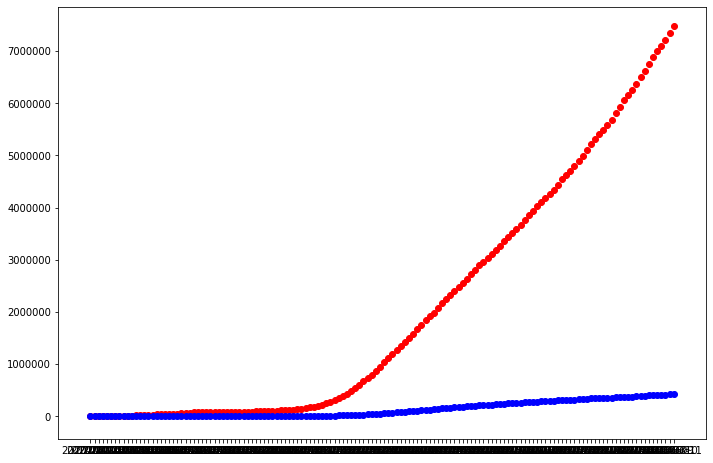

In [22]:
# run this cell twice for the plot #
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0, 0, 1.5, 1.5])
ax.scatter(grouped.index, grouped["Total_Confirmed_Cases"], color='r')
ax.scatter(grouped.index, grouped["Total_Fatalities"], color='b')
plt.show()

# Get the data of the selected countries

In [23]:
Germany = dataset.query('Country_Region=="Germany"')
US     = dataset.query('Country_Region=="US"')
NewZealand = dataset.query('Country_Region=="New Zealand"')
Sweden = dataset.query('Country_Region=="Sweden"')
India = dataset.query('Country_Region=="India"')
countries_to_compare = {"Germany": Germany, "US": US, 'New Zealand': NewZealand, "Sweden": Sweden, "India": India}

# Visualize the number of Total_Confirmed_cases of the all the selected countries 

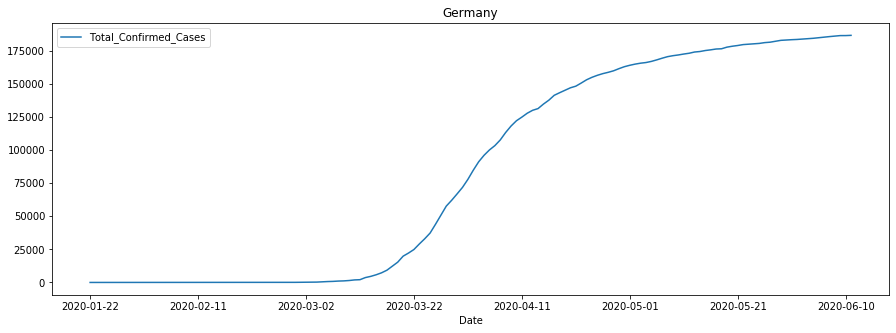

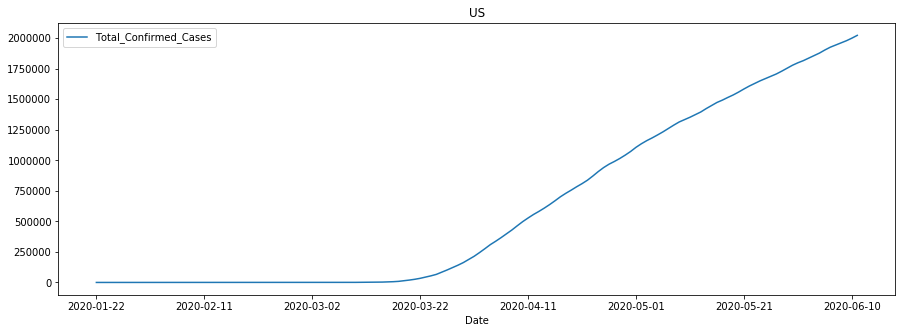

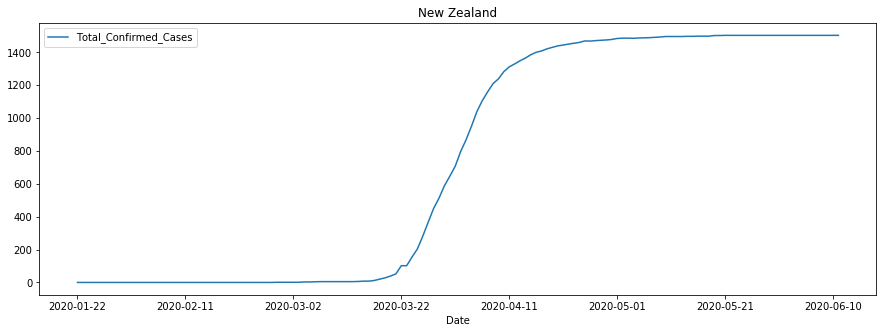

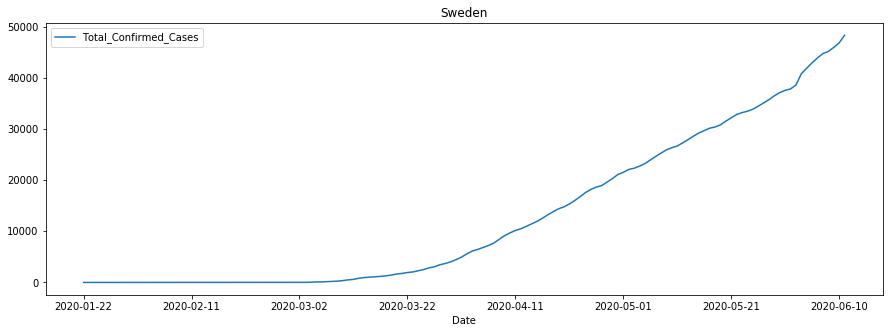

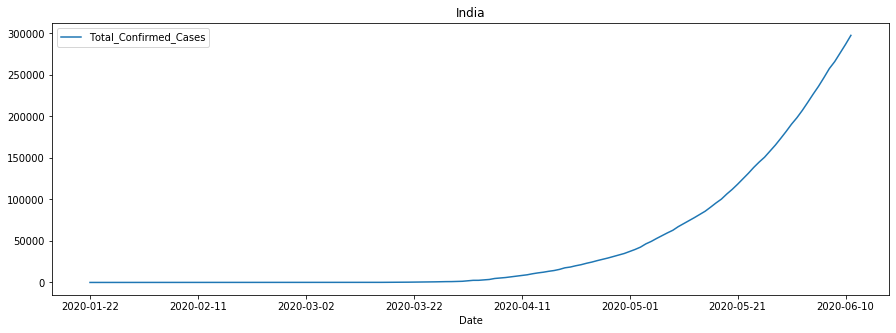

In [24]:
# combine all the line plots in one graph with different colors and names.
for country in countries_to_compare.keys():
    countries_to_compare[country].plot(x='Date', y='Total_Confirmed_Cases', title=country, figsize=(15, 5))

# Visualize the number of Total_Fatalities of the all the selected countries 

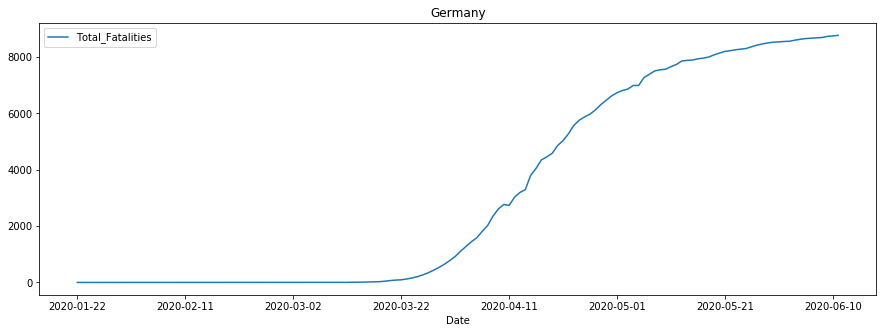

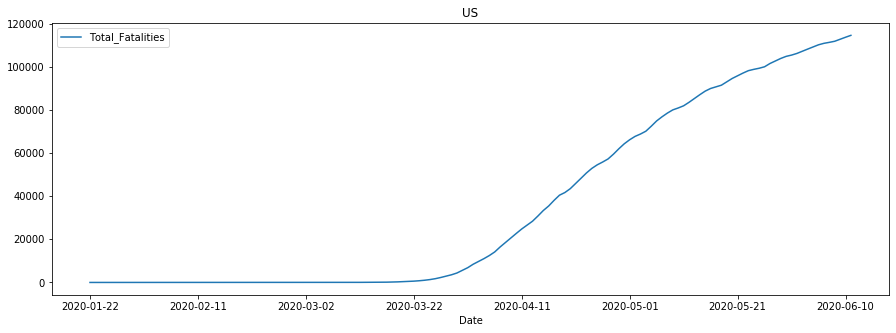

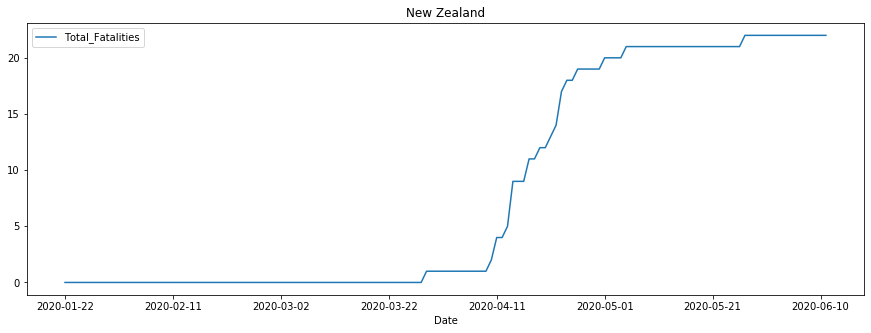

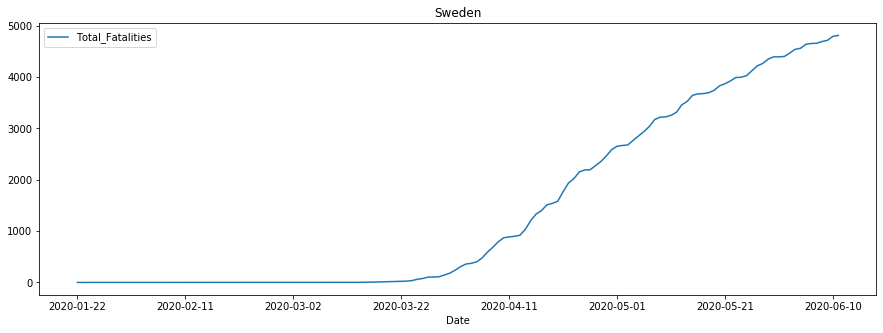

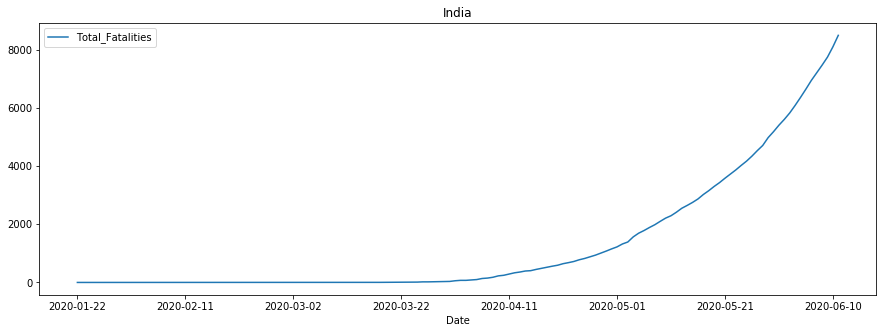

In [25]:
# combine all the line plots in one graph with different colors and names.
for country in countries_to_compare.keys():
    countries_to_compare[country].plot(x='Date', y='Total_Fatalities', title=country, figsize=(15, 5))

# Visualize all countries total confirmed cases together

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

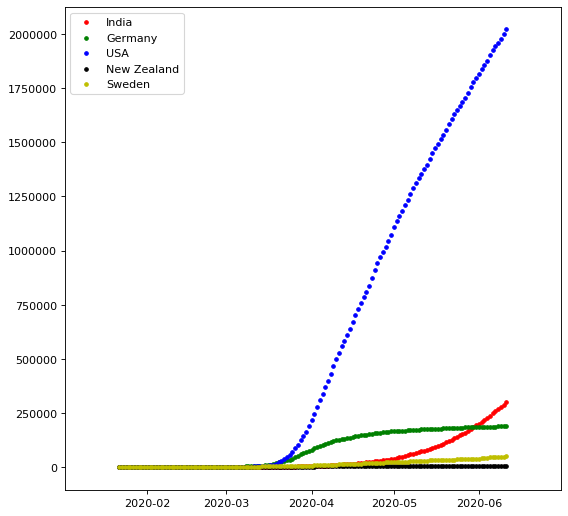

In [26]:
ind = dataset[dataset["Country_Region"] == "India"]
ind['Date'] =  pd.to_datetime(ind['Date'])

germany = dataset[dataset["Country_Region"] == "Germany"]
germany['Date'] =  pd.to_datetime(germany['Date'])

us = dataset[dataset["Country_Region"] == "US"]
us['Date'] =  pd.to_datetime(us['Date'])

nz = dataset[dataset["Country_Region"] == "New Zealand"]
nz['Date'] =  pd.to_datetime(nz['Date'])

swe = dataset[dataset["Country_Region"] == "Sweden"]
swe['Date'] =  pd.to_datetime(swe['Date'])

fig = plt.figure(figsize=(8, 8), dpi=80)
ax1 = fig.add_subplot(111)

ax1.scatter(ind['Date'], ind["Total_Confirmed_Cases"], s=10, c='r', label='India')
ax1.scatter(germany['Date'], germany["Total_Confirmed_Cases"], s=10, c='g', label='Germany')
ax1.scatter(us['Date'], us["Total_Confirmed_Cases"], s=10, c='b', label='USA')
ax1.scatter(nz['Date'], nz["Total_Confirmed_Cases"], s=10, c='black', label='New Zealand')
ax1.scatter(swe['Date'], swe["Total_Confirmed_Cases"], s=10, c='y', label='Sweden')
plt.legend(loc='upper left');
plt.show()

# Use prophet to predict feature Covid 19 cases and death

1. Build re-usable functions

In [27]:
def get_ds_y(countryDataFrame, y_column):
    newDataFrame = pd.DataFrame()
    newDataFrame['ds'] = countryDataFrame['Date']
    newDataFrame['y'] = countryDataFrame[y_column]
    return newDataFrame


In [28]:
def forecastCases(countryData, days=30):# default num of days.
    p = prophet.Prophet(interval_width=0.95) # allow 5% of error.
    p.fit(countryData)
    countryFeatureDF = p.make_future_dataframe(periods=days)
    countryForecast = p.predict(countryFeatureDF)
    p.plot_components(countryForecast)
    
    return countryForecast # get your range values from this.    

# 1. Forecasting for India

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,468050.000887,440323.364544,497633.561289
168,2020-07-08,475621.190583,446208.732149,505320.056232
169,2020-07-09,483044.598605,452161.208166,513682.954279
170,2020-07-10,489358.702467,457853.633712,522231.707803
171,2020-07-11,496759.845014,461484.301993,531507.789188


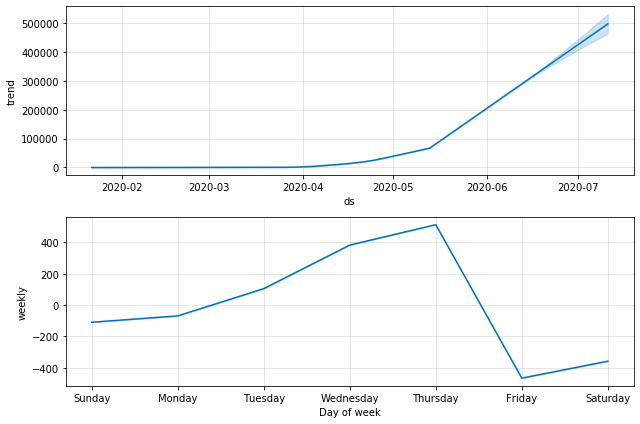

In [29]:
India_ds_y = get_ds_y(India, "Total_Confirmed_Cases")
country_forecast = forecastCases(India_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,12666.470493,11895.625774,13383.793530
168,2020-07-08,12866.147268,12133.294547,13626.205438
169,2020-07-09,13065.258341,12251.815210,13839.068033
170,2020-07-10,13219.744430,12413.315249,14038.879885
171,2020-07-11,13412.036953,12534.646928,14281.065806


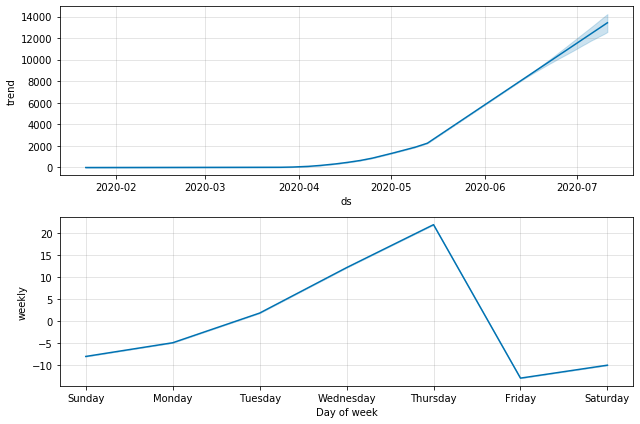

In [30]:
India_ds_y = get_ds_y(India, "Total_Fatalities")
country_forecast = forecastCases(India_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# 2. Forecast for Germany

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,199095.959269,157624.680896,241271.688136
168,2020-07-08,199782.884015,156666.615585,243703.474662
169,2020-07-09,200434.292426,154777.148511,247057.326893
170,2020-07-10,201304.279597,153316.043062,250552.515943
171,2020-07-11,201618.073863,151548.783503,252824.132696


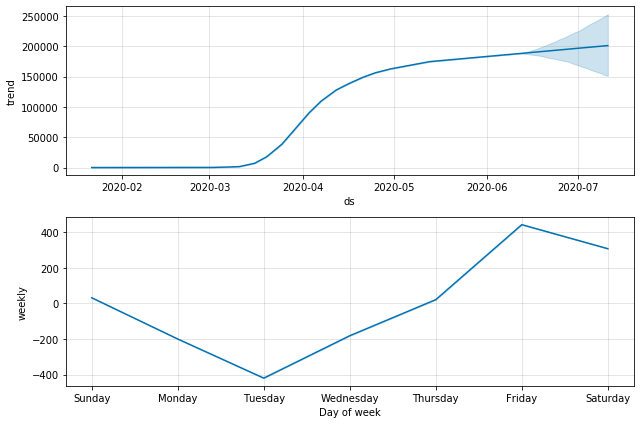

In [31]:
Germany_ds_y = get_ds_y(Germany, "Total_Confirmed_Cases")
country_forecast = forecastCases(Germany_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,9717.596838,8070.583389,11249.103518
168,2020-07-08,9788.254778,8056.397015,11403.297223
169,2020-07-09,9833.179192,7933.571113,11525.501854
170,2020-07-10,9874.207843,7904.287072,11678.864827
171,2020-07-11,9878.848733,7756.842748,11709.955351


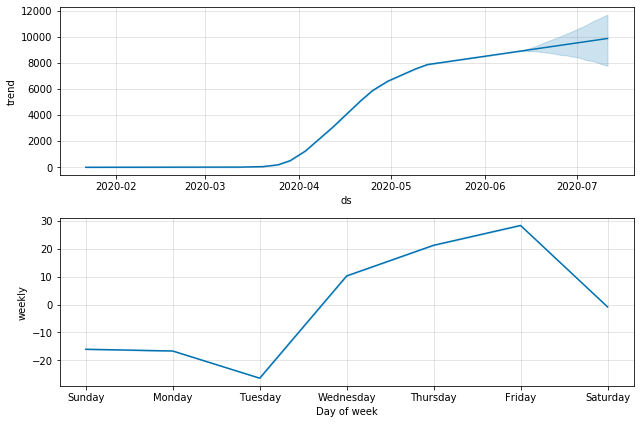

In [32]:
Germany_ds_y = get_ds_y(Germany, "Total_Fatalities")
country_forecast = forecastCases(Germany_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# 3. Sweden forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,62576.977069,60001.865160,65276.874520
168,2020-07-08,63356.465666,60716.555863,66165.862266
169,2020-07-09,64113.513702,61225.903427,67123.041437
170,2020-07-10,64703.776809,61756.357497,67862.017128
171,2020-07-11,65341.688100,62250.575323,68390.533981


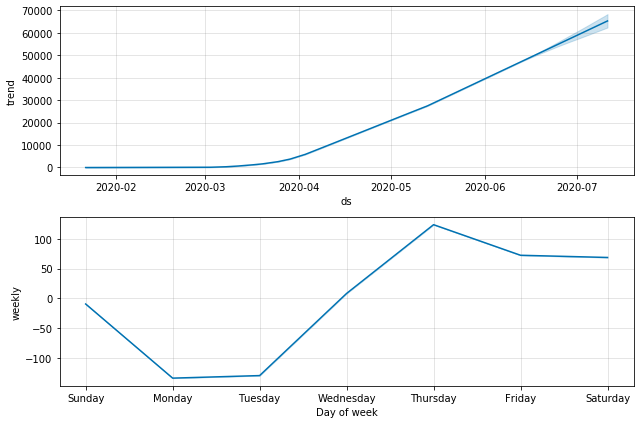

In [33]:
Sweden_ds_y = get_ds_y(Sweden, "Total_Confirmed_Cases")
country_forecast = forecastCases(Sweden_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,6139.520358,5625.867772,6651.613006
168,2020-07-08,6211.899917,5658.162445,6761.198763
169,2020-07-09,6265.724712,5682.434130,6855.655547
170,2020-07-10,6330.369420,5700.702104,6962.248806
171,2020-07-11,6364.794448,5738.728887,6998.539082


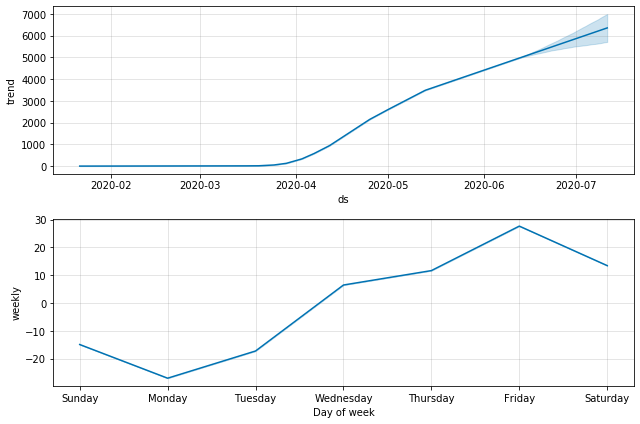

In [34]:
Sweden_ds_y = get_ds_y(Sweden, "Total_Fatalities")
country_forecast = forecastCases(Sweden_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# 4. Forecast for US

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,2.586749e+06,2.417474e+06,2.763396e+06
168,2020-07-08,2.607915e+06,2.422343e+06,2.797437e+06
169,2020-07-09,2.630970e+06,2.432578e+06,2.828525e+06
170,2020-07-10,2.654846e+06,2.449471e+06,2.863089e+06
171,2020-07-11,2.676938e+06,2.461832e+06,2.893794e+06


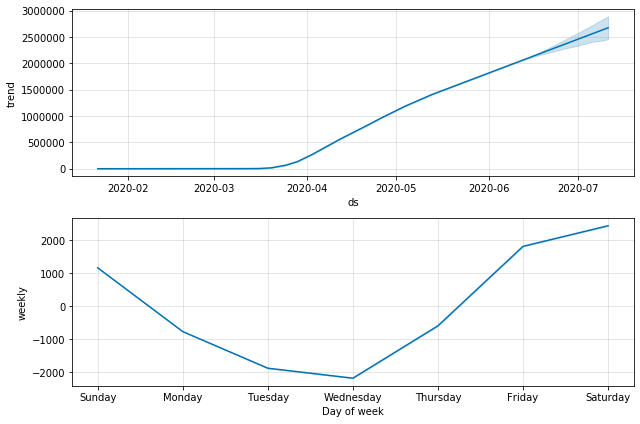

In [35]:
US_ds_y = get_ds_y(US, "Total_Confirmed_Cases")
country_forecast = forecastCases(US_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,141733.268725,129481.076369,153734.168607
168,2020-07-08,142897.178025,129893.907839,155832.324107
169,2020-07-09,144005.059426,130340.715268,157209.057395
170,2020-07-10,145170.205627,130605.531115,159402.346966
171,2020-07-11,146108.145092,130836.355209,161105.015134


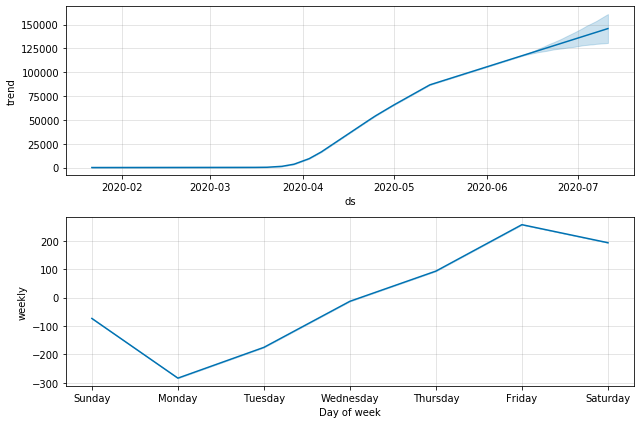

In [36]:
US_ds_y = get_ds_y(US, "Total_Fatalities")
country_forecast = forecastCases(US_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# 5. Forecast New Zealand Total cases and Death toll

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,2265.777213,1744.657925,2790.059676
168,2020-07-08,2290.284347,1806.141325,2838.560096
169,2020-07-09,2302.254239,1779.585998,2854.279700
170,2020-07-10,2332.355915,1801.217300,2843.410754
171,2020-07-11,2345.209886,1824.952769,2890.323999


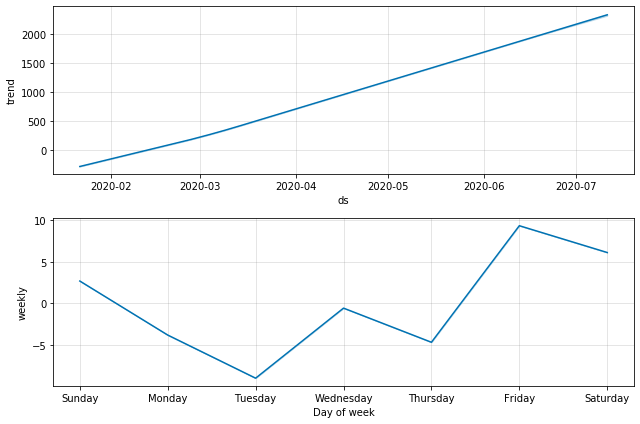

In [37]:
# predict total cases
NZ_ds_y = get_ds_y(NewZealand, "Total_Confirmed_Cases")
country_forecast = forecastCases(NZ_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
167,2020-07-07,35.001089,29.157013,40.660025
168,2020-07-08,35.312244,29.332017,41.345611
169,2020-07-09,35.562087,29.684724,41.104489
170,2020-07-10,36.162913,30.229805,42.592618
171,2020-07-11,36.371120,30.649052,42.479347


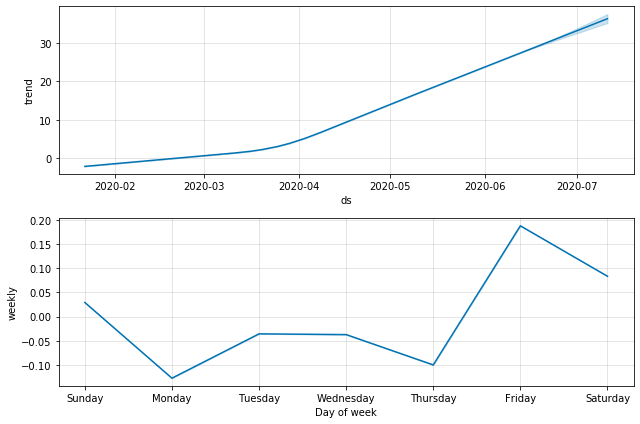

In [38]:
# predict total fatalities
NZ_ds_y = get_ds_y(NewZealand, "Total_Fatalities")
country_forecast = forecastCases(NZ_ds_y)
country_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()